In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import IPython.display
import scipy
from scipy import signal
import librosa

# import spcom

<StemContainer object of 3 artists>

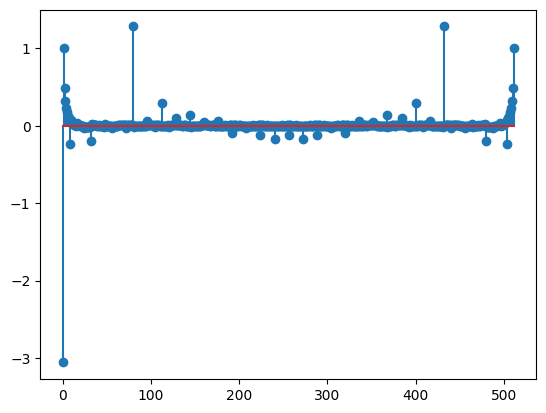

In [2]:
# 音声ファイル chap06_synth_vowel.wav を読み込む
# sr=None とすることで，ファイルに埋め込まれた元のサンプリング周波数をそのまま使う
s, sr = librosa.load("chap06_synth_vowel.wav", sr=None)

# 解析に用いるフレーム長（サンプル数）を指定
# ここでは 512 サンプルぶんの短時間フレームを取り出してケプストラム解析を行う
nFFT = 512

# 先頭 nFFT サンプルに Hann 窓を掛けてから実数 FFT（rFFT）を計算
# ・窓掛け：フレーム端での不連続を緩和し，スペクトルリークを抑える
# ・rFFT：実数信号に対して片側スペクトルのみを返す高速 FFT
S = np.fft.rfft(s[:nFFT] * np.hanning(nFFT))

# 振幅スペクトルの対数を取る
# ケプストラムは「対数振幅スペクトルの逆 FFT」で定義されるため，
# ここで log |S(ω)| を計算しておく
LS = np.log(np.abs(S))

# 対数振幅スペクトル LS に対して逆 rFFT を計算し，
# 実ケプストラム（real cepstrum） c[n] を求める
# ・時間軸ではなく「ケプストラム軸（ケフレンシ）」上の情報となり，
#   低ケフレンシ側：スペクトル包絡（フォルマントなど）に対応
#   高ケフレンシ側：ピッチ周期など細かい周期構造に対応
c = np.fft.irfft(LS)

# 得られたケプストラム係数 c[n] をステムプロットで可視化
# 棒グラフ状に描くことで，各ケフレンシ成分の寄与を見やすくする
plt.stem(c)

(-120.0, 120.0)

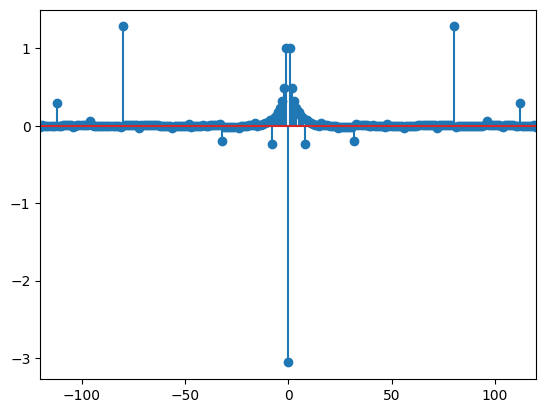

In [3]:
# 直前で計算した実ケプストラム c を，中心が 0 になるように並べ替えて可視化するコード

plt.close()

# ケプストラム係数 c のインデックス軸を，中央が 0 になるように定義
# ・len(c) 個のサンプルに対して 0,1,...,len(c)-1 という添字ではなく
#   -len(c)/2 〜 +len(c)/2 のような左右対称な軸 x を作る
# ・これにより，後で fftshift した c と組み合わせると，
#   「ケフレンシ（quefrency）= 0」がグラフの中央に来るようになる
x = np.arange(len(c)) - len(c) / 2

# ケプストラム c を fftshift で並べ替える
# ・fftshift はスペクトルの DC 成分（ここではケフレンシ 0 付近）を
#   配列の中央に移動させる操作
# ・通常のケプストラム c は 0,1,2,... の順に並んでいるが，
#   fftshift(c) によって「負のケフレンシ成分」を左側に，「正のケフレンシ成分」を右側に
#   持つような見た目になる（実装上は循環シフト）
# ・x と組み合わせて stem プロットすることで，
#   ケフレンシ軸が -N/2 〜 +N/2 に対称なグラフとして解釈しやすくなる
plt.stem(x, np.fft.fftshift(c))

# x 軸を [-120, 120] に制限
# ・全ケフレンシを描くと，興味のある低〜中ケフレンシ領域（ピッチ周期や包絡構造に対応）が
#   小さくつぶれてしまう
# ・ここでは |x| <= 120 の範囲にズームインすることで，
#   低ケフレンシ側（スペクトル包絡）と中ケフレンシ側（基本周期付近）の振る舞いを
#   詳細に観察できるようにしている
# ・たとえば，ピッチ周期に対応するピークが ±数十サンプル付近に現れるかどうかを確認できる
plt.xlim([-120, 120])

In [4]:
# ケプストラム c を fftshift した配列の，中心付近 5 サンプルだけを取り出す
# ・len(c) = 512 のとき，fftshift(c) の「中心インデックス」は 256 付近になる
#   - fftshift は配列を半分ずらすので，もともと 0 番目にあったケフレンシ 0 成分が
#     中央付近（ここでは 256 付近）に移動していると考えられる
# ・[256-2 : 256+3] は，インデックス 254, 255, 256, 257, 258 の 5 要素を切り出すスライス
#   - つまり「ケフレンシ 0 近傍（スペクトル包絡に強く関係する成分）」を局所的に観察している
#   - これらの値の大きさや符号は，対数スペクトルのなめらかさ・低ケフレンシ構造を反映する
# ・解析の意図としては，
#   - ケプストラムの中心付近がどの程度大きいか
#   - 有声音／無声音でどのように変化するか
#   を数値として確認したり，閾値設定の参考にする用途が考えられる
np.fft.fftshift(c)[256 - 2 : 256 + 3]

array([ 0.49027449,  0.996928  , -3.05624003,  0.996928  ,  0.49027449])

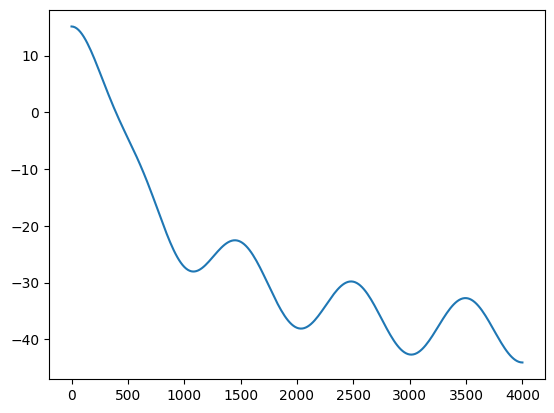

In [5]:
# 以前に計算したケプストラム c から，「低ケフレンシ成分だけ」を取り出して
# 平滑化された対数スペクトル（スペクトル包絡）を復元してプロットする処理

plt.close()

# ケプストラムの有効次数（ケプストラム係数の何次まで残すか）
# ・一般に order が大きいほど細かい凹凸まで表現できる（＝包絡がシャープになる）
# ・ここでは 14 次まで残しているので，「14 次ケプストラムによる包絡」と解釈できる
order = 14

# cGVLow は「低ケフレンシ成分のみを残したケプストラム」を格納する配列
# ・c そのものへの参照になっている点に注意（後続で c 自体も書き換わる）
#   仮に c を残しておきたい場合は c.copy() を使う方が安全：
#   例）cGVLow = c.copy()
cGVLow = c

# 中心付近の低次成分（0〜order および末尾側の対称な成分）だけ残し，
# それ以外の高ケフレンシ成分を 0 にする「リフタリング」を行う
# ・ケプストラムは実数対称構造を持つので，
#   低ケフレンシ成分を残すには前後対称に同じインデックス範囲を残す必要がある
# ・ここでは 0〜order および末尾側 order 個を残し，
#   それ以外（インデックス order+1〜-order-1）を 0 にしている
cGVLow[order + 1 : -order] = 0

# ケプストラム（対数スペクトルの逆 FFT）を再び FFT することで，
# 平滑化された対数スペクトル（GVLow）を復元する
# ・もともと LS = log|S|（自然対数）の rFFT→iFFT で c を得ているので，
#   ここでの rFFT(cGVLow) は「高周波ケフレンシ成分を落とした log|S|」に対応
# ・数値誤差で虚部がわずかに残ることがあるので np.real で実数部のみ取り出す
GVLow = np.real(np.fft.rfft(cGVLow))

# 周波数軸を生成
# ・rFFT の出力長に対応する 0〜sr/2 までの周波数ベクトル
f = np.fft.rfftfreq(nFFT, 1 / sr)

# GVLow は自然対数（ln）スケールなので，20*GVLow/ln(10) で dB 表示に変換する
# ・一般的な「20 log10 |H(f)|」に対応する形
# ・ここでの |H(f)| は，原スペクトルの包絡のみを表す平滑なスペクトルと解釈できる
plt.plot(f, 20 * GVLow / np.log(10))

# （必要に応じて）
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude (dB)')
# plt.title('Smoothed log spectrum via low-order cepstrum (order = 14)')

<StemContainer object of 3 artists>

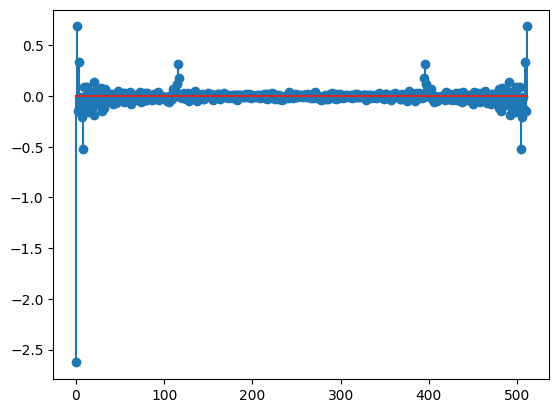

In [7]:
plt.close()


# ============================
# ケプストラムを求める関数
# ============================
def cepstrum(S):
    # 振幅スペクトルの自然対数を取る
    # ケプストラムは「log|S(ω)| の逆 FFT」で定義されるため，
    # まず複素スペクトル S から絶対値を取り log を計算する
    LS = np.log(np.abs(S))
    # 片側スペクトル（rFFT）の log|S| に対して逆 rFFT を行い，
    # 実ケプストラム（real cepstrum）を返す
    return np.fft.irfft(LS)


# ============================
# リフタリング（低ケフレンシのみ残す）
# ============================
def liftering(in_ceps, order=14):
    # 入力ケプストラムをコピーして，新しい配列として扱う
    # （元の in_ceps を破壊しないための defensive copy）
    out_ceps = in_ceps.copy()
    # 低次のケプストラム係数（0〜order）と末尾側の対称な係数だけ残し，
    # それ以外の高ケフレンシ成分を 0 にする
    # これにより「スペクトル包絡」に対応する滑らかな log スペクトルだけを取り出せる
    out_ceps[order + 1 : -order] = 0
    return out_ceps


# ============================
# 音声読み込み ＋ プリエンファシス
# ============================
# /sa/ 音声を読み込む（ここでは 48 kHz のファイルを 16 kHz にリサンプリング）
ySa, sr = librosa.load("sa48k.wav", sr=16000)

# プリエンファシスフィルタを適用
# y[n] = x[n] - 0.97 x[n-1]
# 低域を減衰させ，高域の傾きを補正してスペクトルをフラットに近づける
ySa = signal.lfilter([1, -0.97], 1, ySa)

# ============================
# フレーム切り出し ＋ 窓掛け
# ============================
nFFT = 512  # ケプストラム解析に用いるフレーム長（FFT サイズ）

# /sa/ の 7000 サンプル目から nFFT 分のフレームを取り出し，
# Hann 窓を掛けてスペクトルリークを抑える
yA = ySa[7000 + np.arange(nFFT)] * np.hanning(nFFT)

# ============================
# ケプストラムの計算
# ============================
# 実数信号の片側スペクトルを rFFT で計算
SA = np.fft.rfft(yA)

# 対数振幅スペクトルの逆 FFT により実ケプストラムを求める
# cA[n] は「ケフレンシ（quefrency）」軸上の信号となり，
# 小さい n 付近がスペクトル包絡，大きい n 付近がピッチ周期などの微細構造に対応する
cA = cepstrum(SA)

# 低ケフレンシ成分のみを残したケプストラム（スペクトル包絡用）
# order=20 にすると，20 次までの係数で包絡を表現することになる
cALow = liftering(cA, 20)

# ============================
# ケプストラムの可視化
# ============================
# ここではまず「元のケプストラム cA 全体」をステムプロットすることで，
# どのケフレンシ領域にエネルギーが集中しているかを観察する
# （必要に応じて cALow をプロットすると，包絡だけを表す滑らかな構造との比較もできる）
plt.stem(cA)
# 例：
# plt.figure(); plt.stem(cALow) とすれば，
# 低ケフレンシのみ残したケプストラム形状（＝スペクトル包絡成分）を確認できる

<StemContainer object of 3 artists>

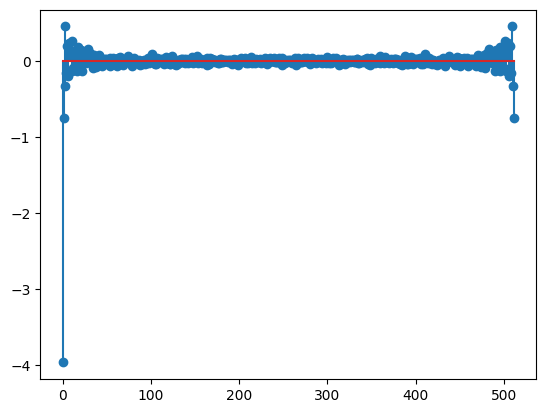

In [8]:
plt.close()

# ============================
# /sa/ の別フレームに対するケプストラム解析
# ============================
# ここでは，すでに定義済みの
#   - ySa    : プリエンファシス済みの /sa/ 音声
#   - nFFT   : 解析に用いるフレーム長（FFT サイズ）
#   - cepstrum(), liftering() : 先に定義した関数
# を再利用して，/sa/ の「別の時間位置」のフレームを解析している。

# 2500 サンプル目から nFFT サンプルぶん切り出して Hann 窓を掛ける
# ※先ほどのコードでは 7000 サンプル目からフレームを切り出しており，
#   そちらは有声音（母音部）に近い区間である可能性が高い。
#   一方，2500 サンプル付近は摩擦音 /s/ に相当する無声音区間とみなせることが多く，
#   2 つを比較することで「有声音 vs 無声音のケプストラムの違い」を観察できる。
SS = np.fft.rfft(ySa[2500 + np.arange(nFFT)] * np.hanning(nFFT))

# 対数振幅スペクトルの逆 FFT を用いて実ケプストラム cS を求める
# - 有声音フレームのケプストラム cA に対し，
#   無声音フレームのケプストラム cS がどう違うか（周期構造が弱い／ノイズ的か）を
#   比較するのが主な解析の狙いと考えられる。
cS = cepstrum(SS)

# 低ケフレンシ成分のみを残したケプストラム（スペクトル包絡成分）も同時に計算
# - order=20 なので，ケプストラム 20 次まででスペクトル包絡を表現する「低次ケプストラム」
# - この cSLow から rFFT → dB 変換することで，
#   /s/ 区間のスペクトル包絡（ノイズ的なエネルギー分布）を抽出できる
cSLow = liftering(cS, 20)

# 無声音フレームに対する元のケプストラム cS 全体を可視化
# - 有声音（ピッチ構造が強い区間）では，
#   ケフレンシがピッチ周期付近にピークを持つことが多い。
# - 無声音（ノイズ的区間）では，
#   高ケフレンシ側の周期構造は目立たず，
#   主に低ケフレンシ側にエネルギーが分布する傾向がある。
# - cA（有声音）と cS（無声音）のステムプロットを並べて見ることで，
#   「ケプストラムによる有声・無声音の特徴の差」を直感的に理解できる。
plt.stem(cS)

In [9]:
def glottalPulse(fs, T1=0.004, T2=0.002):
    """
    声門波形（グロッタルパルス）1周期分を生成する関数

    パラメータ
    ----------
    fs : float
        サンプリング周波数 [Hz]
    T1 : float
        立ち上がり（開大）区間の長さ [s]
        0 〜 T1 の間で徐々に振幅が増加する部分
    T2 : float
        閉鎖区間（減衰）に相当する長さ [s]
        T1 〜 T1+T2 の間で振幅が 0 に向かって減少する部分

    戻り値
    ------
    g : ndarray
        1周期分の声門波形（時間長 T1+T2 のみ）
        この波形をインパルス列と畳み込むことで，
        周期的な声門源（source）信号を作ることができる。
    """

    # 0 〜 T1 秒の時間軸をサンプリング
    # 開大フェーズ（声門が開いていく区間）の時間サンプル
    t1 = np.arange(0, T1, 1 / fs)

    # 開大フェーズの波形 g1 を Hann 型の形で定義
    # 0.5 * (1 - cos(θ)) は，0→1 にスムーズに立ち上がる窓関数になる
    # → 立ち上がりを滑らかにすることで，高域に不要な成分が出にくくなる
    g1 = 0.5 * (1 - np.cos(2 * np.pi * t1 / (2 * T1)))

    # T1 〜 T1+T2 秒の時間軸をサンプリング
    # 閉鎖フェーズ（声門が閉じていく区間）の時間サンプル
    t2 = np.arange(T1, T1 + T2, 1 / fs)

    # 閉鎖フェーズの波形 g2
    # cos 関数を使って 1→0 に減衰する形を作っている
    # 2π*(t2-T1)/(4*T2) というスケーリングにより，T2 の間で
    # cos が 1 から 0 付近まで滑らかに変化する
    g2 = np.cos(2 * np.pi * (t2 - T1) / (4 * T2))

    # 開大フェーズ g1 と閉鎖フェーズ g2 を連結して 1周期の声門波形を作る
    # その後，必要であれば 0 区間（無音区間）を後ろに足すことで，
    # 任意の基本周期長 T0 に拡張することができる
    return np.hstack((g1, g2))


def freqz_two_tube(f, rL, rG, r1, L, c, L1L2):
    """
    2 セクション管モデル（簡易声道モデル）の周波数特性 H(f) を計算する関数

    パラメータ
    ----------
    f : ndarray
        周波数軸 [Hz]（0 〜 fs/2 のような 1 次元配列）
    rL : float
        口唇（Lips）での反射係数
        - |rL| < 1 であればエネルギーが一部放射され，一部が反射される
    rG : float
        声門（Glottis）での反射係数
        - 声門側境界条件を反映するパラメータ
    r1 : float
        2 つの管セクションの境界（junction）での反射係数
        - 断面積（あるいは音響インピーダンス）の不連続により生じる反射をモデル化
    L : float
        全体の管長 [m]
    c : float
        音速 [m/s]
    L1L2 : float
        第 1 セクションと第 2 セクションの長さの比 L1/L2
        - これにより，境界位置（セクション分割）が決まる

    戻り値
    ------
    H : ndarray (complex)
        周波数 f における 2 セクション管モデルの周波数特性 H(f)

    理論的背景
    ----------
    ・1 次元波動方程式の解としての進行波・反射波を，
      反射係数 rL, rG, r1 と遅延時間（L, L1, L2）で表した伝達関数。

    ・分子：
        0.5 * (1 + rG) * (1 + rL) * r1 * exp(-j 2π f L / c)
      は，入射波が管内を伝搬しつつ，境界での透過を受けて
      観測点に到達するゲインと位相遅延をまとめたもの。

    ・分母：
        1
        + r1 rG exp(-j 2π f * 2 L1 / c)
        + r1 rL exp(-j 2π f * 2 L2 / c)
        + rL rG exp(-j 2π f * 2 L  / c)
      は，声門・口唇・セクション境界での反射を繰り返す多重経路（エコー）を
      幾何級数的にまとめた形になっており，
      その極（ポール）の位置がフォルマント（共鳴周波数）を決定する。

    ・実装では L1, L2 を L と L1L2 から相対的に表現している：
        L1 = L * L1L2 / (1 + L1L2)
        L2 = L * 1      / (1 + L1L2)
      → コード中の「2*L1L2/(L1L2+1)*L」や「2/(1+L1L2)*L」が
        それぞれ 2L1, 2L2 に対応する。
    """

    # 便宜上，指数部以外のスカラー係数を先にまとめておく
    # 0.5*(1+rG)*(1+rL)*r1 は，入射波が声門・口唇・境界で透過されるときの
    # 振幅スケーリングをまとめて表している
    numerator = 0.5 * (1 + rG) * (1 + rL) * (1 * r1)

    # 周波数 f を角周波数 2πf に変換し，
    # 位相遅延 exp(-j 2π f L / c) を掛けることで，
    # 管長 L [m] を音波が伝搬する際の時間遅延（L/c [s]）を表現する
    main_delay = np.exp(-2j * np.pi * f * L / c)

    # 各経路の遅延時間を長さ比 L1L2 を使って表現
    # L1 = (L1L2 / (L1L2 + 1)) * L
    # L2 = (1      / (L1L2 + 1)) * L
    # ・2*L1/c, 2*L2/c, 2*L/c がそれぞれ往復時間に対応
    term_G = r1 * rG * np.exp(-2j * np.pi * f * 2 * L1L2 / (L1L2 + 1) * L / c)
    term_L = r1 * rL * np.exp(-2j * np.pi * f * 2 / (1 + L1L2) * L / c)
    term_GL = rL * rG * np.exp(-2j * np.pi * f * 2 * L / c)

    # 分母は「1 + 3 つの反射経路の寄与」を足し合わせた形
    # これが 0 に近づく周波数で |H(f)| が大きくなり，フォルマントとして観測される
    denominator = 1 + term_G + term_L + term_GL

    # 周波数特性 H(f) を返す
    return numerator * main_delay / denominator

In [10]:
def twoTubeSynth(fs, f0=100, L=0.176, c=352, rL=0.7, rG=1, a1a2=1 / 8, L1L2=1.2):
    """
    2 セクション管モデル（two-tube model）を用いて母音っぽい音声を合成する関数

    パラメータ
    ----------
    fs : float
        サンプリング周波数 [Hz]
    f0 : float, default 100
        基本周波数（ピッチ）[Hz]
        → 1/f0 [s] ごとに声門パルスを発生させる
    L : float, default 0.176
        声道全体の長さ [m]
    c : float, default 352
        音速 [m/s]（温度などで変化するが、ここでは固定）
    rL : float, default 0.7
        口唇側の反射係数（lips）
    rG : float, default 1
        声門側の反射係数（glottis）
    a1a2 : float, default 1/8
        2 つの管セクションの断面積の比 a1/a2
        → セクション境界での反射係数 r1 を決める
    L1L2 : float, default 1.2
        第1管長と第2管長の比 L1/L2
        → セクション境界の位置を決める

    戻り値
    ------
    y : ndarray (1 次元)
        two-tube 声道モデルを通した合成音声波形（約 1 秒分）
    """

    # -------------------------
    # 1. セクション境界の反射係数 r1 を計算
    # -------------------------
    # 断面積比 a1/a2 から，音響インピーダンスの不連続に由来する反射係数 r1 を計算
    # r1 = (Z2 - Z1) / (Z2 + Z1) を，断面積比 a1/a2 でパラメタライズした形
    # （ここでは簡略化して (1-a1a2)/(1+a1a2) としている）
    r1 = (1 - a1a2) / (1 + a1a2)

    # -------------------------
    # 2. 1周期ぶんの声門パルス g(t) を生成
    # -------------------------
    # glottalPulse(fs) は，時間長 T1+T2 の 1周期の声門波形（開大〜閉鎖）を返す
    # この g をインパルス列と畳み込むことで，周期的な声門源信号が得られる
    g = glottalPulse(fs)

    # -------------------------
    # 3. 声門パルスを打つインパルス列 x_imp を作成
    # -------------------------
    # 1周期の長さ [s]（ピッチ周期）
    imp_len = 1 / f0

    # 1周期におけるサンプル数を計算し，偶数になるように丸める
    # ・imp_len * fs : 1周期ぶんのサンプル数
    # ・/2 → *2 にしているのは「最も近い偶数」にそろえるため
    #   （周波数分解能や対称性を意識した設計）
    nimp = int(np.round(imp_len * fs / 2)) * 2

    # 1周期ぶんのインパルス列（先頭のみ1で残り0）
    # imp = [1, 0, 0, ..., 0]（長さ nimp）
    imp = np.zeros(nimp)
    imp[0] = 1

    # 1秒間分のインパルス列を複製して作成
    # ・imp_len ≈ 1/f0 なので，1秒間には約 1/imp_len = f0 回のパルスが必要
    # ・np.matlib.repmat(imp, 1, N) により，imp を横方向に N 回並べる
    #   → 形状 (1, nimp * N) のインパルス列になる
    x_imp = np.matlib.repmat(imp, 1, int(round(1 / imp_len)))

    # -------------------------
    # 4. 声門パルス g とインパルス列 x_imp を畳み込み
    # -------------------------
    # FIR フィルタ g をインパルス列 x_imp にかけることで，
    # 各インパルス位置に g が貼り付いた「周期的な声門源」 y_glottal を生成
    # ・signal.lfilter(g, 1, x_imp):
    #   y[n] = Σ_k g[k] x_imp[n-k]（g がインパルス応答）
    y_glottal = signal.lfilter(g, 1, x_imp)

    # -------------------------
    # 5. two-tube 声道モデルの周波数応答 V(f) を計算
    # -------------------------
    # y_glottal の長さから周波数ビン数を決定
    # ・shape[1] はサンプル数（約 fs*1秒）
    # ・0〜fs/2 まで 1 Hz 刻みになるように 0〜N/2-1 を周波数[Hz]として使っている
    f = np.arange(0, int(y_glottal.shape[1] / 2))

    # two-tube モデルの周波数特性 V(f) を計算
    # ・freqz_two_tube は，f [Hz] に対して H(f) を返す
    # ・rL, rG, r1, L, c, L1L2 により，フォルマント構造が決まる
    V = freqz_two_tube(f, rL, rG, r1, L, c, L1L2)

    # -------------------------
    # 6. 声門源のスペクトルと声道フィルタのスペクトルを掛け合わせる
    # -------------------------
    # 声門源 y_glottal の片側スペクトル
    # y_glottal は 2 次元 (1, N) なので，rFFT の結果も (1, N/2+1)
    S_glottal = np.fft.rfft(y_glottal)

    # V は長さ N/2 だが，rFFT の出力は N/2+1 なので，
    # 末尾に 0 を 1 つ足して長さを合わせる（直流〜Nyquist まで）
    # ・本来であれば V の定義を N/2+1 点で計算するのがより厳密だが，
    #   ここでは簡便のため np.append(V, 0) で整合させている
    S = S_glottal * np.append(V, 0)

    # -------------------------
    # 7. 時間領域に戻して合成音声を得る
    # -------------------------
    # rFFT の逆変換で時間波形に戻す
    # 出力は (1, N) なので，先頭チャネル [0, :] を取り出して 1 次元配列として返す
    return np.fft.irfft(S)[0, :]

In [11]:
plt.close()

# twoTubeSynth を用いて two-tube 声道モデルから母音風の音声を合成する
# 引数の意味は：
#   sr    : サンプリング周波数（既にどこかで定義されていると仮定）
#   131   : 基本周波数 f0 = 131 Hz（おおよそ男性低めの声のピッチ）
#   0.17  : 声道の全長 L = 17 cm
#   340   : 音速 c ≒ 340 m/s
#   0.7   : 口唇側反射係数 rL
#   1.0   : 声門側反射係数 rG
#   1/7   : 断面積比 a1/a2（境界反射係数 r1 を決める）
#   1     : 管長比 L1/L2
# これにより，フォルマント構造が決まった two-tube モデルで 1 秒分程度の波形を合成する
yA131 = twoTubeSynth(sr, 131, 0.17, 340, 0.7, 1.0, 1 / 7, 1)

# 合成した音声にプリエンファシスフィルタを適用
# y[n] = x[n] - 0.97 x[n-1]
# 低域のスペクトル傾斜（おおまかに 1/f 型）を補正し，高域を相対的に持ち上げることで，
# この後のケプストラム解析や LPC 解析でフォルマント構造を見やすくするための前処理
yA131 = signal.lfilter([1, -0.97], 1, yA131)

# ケプストラム解析に用いるフレーム長を設定
# ここでは 512 サンプル（sr=16kHz なら約 32ms）という典型的な分析窓長
nFFT = 512

# 先頭 nFFT サンプルに Hann 窓を掛けてから rFFT を計算し，複素スペクトル SA131 を得る
# Hann 窓によりフレーム端の不連続を抑え，スペクトルリークを軽減する
SA131 = np.fft.rfft(yA131[np.arange(nFFT)] * np.hanning(nFFT))

# 対数振幅スペクトルの逆 rFFT により実ケプストラム cA131 を計算
# cA131 の低ケフレンシ成分はスペクトル包絡（フォルマント構造）に対応し，
# 高ケフレンシ成分はピッチ周期などの微細な周期構造に対応する
cA131 = cepstrum(SA131)

# ケプストラムの低次成分のみを残すリフタリング
# order=20 なので 20 次までのケプストラム係数でスペクトル包絡を表現する
# → 高ケフレンシ成分（ピッチ由来の細かい凹凸）を落とした滑らかな log スペクトルを抽出できる
cA131Low = liftering(cA131, 20)

# 低次ケプストラム cA131Low をステムプロットすれば，
# two-tube モデル＋プリエンファシス後の「スペクトル包絡の形」を
# ケフレンシ領域で確認することができる
# （必要になったらコメントアウトを外して可視化する）
# plt.stem(cA131Low)

In [12]:
# ============================
# ケプストラム間距離（スペクトル包絡の類似度）の比較
# ============================
# ここまでで用意したケプストラムは：
#   cALow   : 実音声 /a/ のフレームに対する「低ケフレンシのみ」のケプストラム
#             → /a/ のスペクトル包絡（フォルマント構造）を表す
#   cSLow   : 実音声 /sa/ の /s/ 区間（無声音）に対する「低ケフレンシのみ」のケプストラム
#             → /s/ のノイズ的スペクトル包絡
#   cA131Low: two-tube モデルで合成した /a/（f0=131 Hz）の「低ケフレンシのみ」のケプストラム
#             → 合成母音のスペクトル包絡
#
# これらのベクトル差の 2 乗ノルム（ユークリッド距離の 2 乗）を計算することで，
# 「どのスペクトル包絡同士がどれくらい似ているか」を定量的に比較している。

# 1) 実 /a/ vs 実 /s/ のスペクトル包絡の距離
#    ・有声音 /a/ と無声音 /s/ の包絡は性質が大きく異なるため，
#      通常この距離はかなり大きくなるはず
#    ・log スペクトルの差をケプストラム空間で測っているので，
#      「音色の違い」を反映した距離と解釈できる
np.linalg.norm(cALow - cSLow) ** 2

# 2) 実 /a/ vs 合成 /a/ のスペクトル包絡の距離
#    ・two-tube モデルが実 /a/ のフォルマント構造にどれだけ近づいているかを測る指標
#    ・(1) の /a/ vs /s/ よりも十分小さければ，
#      「合成母音の包絡は，無声音よりも実 /a/ に近い」と言える
#    ・two-tube パラメータ（L, a1a2, L1L2, rL, rG など）を調整して
#      この距離を最小化する，という目的関数の候補にもなる
np.linalg.norm(cALow - cA131Low) ** 2

# 3) 実 /s/ vs 合成 /a/ のスペクトル包絡の距離
#    ・無声音 /s/ と合成 /a/ の包絡の違い
#    ・ここも (2) より大きいのが自然な挙動で，
#      そうなっていれば「合成 /a/ は /s/ ではなく /a/ に近い音色を持つ」と解釈しやすい
#    ・(1), (2), (3) の値を比較することで，
#      『実 /a/ にどれだけ寄っているか』を相対的に評価できる
np.linalg.norm(cSLow - cA131Low) ** 2

np.float64(6.023734738562734)

In [13]:
def hz2mel(freq):
    """
    Hz（物理的な周波数）を Mel スケールに変換する関数

    パラメータ
    ----------
    freq : float or ndarray
        変換したい周波数 [Hz]

    戻り値
    ------
    mel : float or ndarray
        Mel スケール上の値

    理論的背景
    ----------
    Mel スケールは，人間の「高さの知覚」がほぼ等間隔になるように
    周波数軸を非線形に変換した尺度。

    代表的な経験式として

        mel(f) = 1127 * ln(1 + f / 700)

    がよく用いられる。
    - 低周波数（〜1 kHz 付近）ではほぼ線形
    - 高周波数になるにつれ，周波数差に対する知覚差が小さくなるため，
      Mel 軸では圧縮される（非線形）

    この関数では，上記の式をそのまま実装している。
    """
    # 自然対数 ln を用いた標準的な近似式
    return 1127 * np.log(1 + freq / 700)


def mel2hz(mel):
    """
    Mel スケールから Hz スケールへ逆変換する関数

    パラメータ
    ----------
    mel : float or ndarray
        Mel スケール上の値

    戻り値
    ------
    freq : float or ndarray
        対応する周波数 [Hz]

    理論的背景
    ----------
    hz2mel() で用いた関係式

        mel = 1127 * ln(1 + f / 700)

    を f について解いたもの：

        mel / 1127 = ln(1 + f / 700)
        exp(mel / 1127) = 1 + f / 700
        f = (exp(mel / 1127) - 1) * 700

    これにより，Mel 軸で等間隔に取った点を，
    元の周波数軸（Hz）に対応付けることができる。
    メルフィルタバンクの中心周波数を求める際などに用いる。
    """
    # hz2mel の式を f について解いた逆変換
    return (np.exp(mel / 1127) - 1) * 700

In [14]:
def melbank(fs=16000, nfft=512, nbank=40, lower=0, upper=8000):
    """
    メルフィルタバンク（triangular mel filter bank）を生成する関数

    パラメータ
    ----------
    fs : int, default 16000
        サンプリング周波数 [Hz]
    nfft : int, default 512
        FFT サイズ（周波数分解能を決める）
    nbank : int, default 40
        メルフィルタの本数（メル周波数軸上の分割数）
    lower : float, default 0
        フィルタバンクの下限周波数 [Hz]
        （※この実装では lower は直接は使っておらず，
           最低周波数側は固定長の三角窓列でカバーしている）
    upper : float, default 8000
        フィルタバンクの上限周波数 [Hz]

    戻り値
    ------
    mel_s_w : ndarray, shape (nbank, nfft/2+1)
        メルフィルタバンクの周波数応答
        - 各行が 1 本の三角形フィルタに対応
        - 各フィルタはエネルギーが 1 になるように正規化されている
    f_c : ndarray, shape (nbank,)
        各メルフィルタの中心周波数 [Hz]

    概要
    ----
    ・低域側（約 0〜1kHz）については，等間隔な線形周波数上に
      固定長の三角窓を重ねる形でフィルタを構成
    ・それ以降の領域（約 1kHz〜upper）については，
      周波数をメルスケールに変換し，メル軸上で等間隔に三角窓の中心を配置してから
      Hz 軸へ戻すことで，メルフィルタバンクを構成する
    """

    # 0 〜 fs/2 を等間隔に離散化した周波数軸（FFT の実部範囲に対応）
    f = np.linspace(0, fs / 2, int(nfft / 2) + 1)

    # メルフィルタバンクの配列を初期化
    #   mel_s_w[フィルタ番号, 周波数ビン] の 2 次元配列
    mel_s_w = np.zeros((nbank, int(nfft / 2) + 1))

    # --------------------------------------------------------
    # 1. 低域側のトライアングルフィルタを構成（線形周波数上）
    # --------------------------------------------------------
    # mel_w_len1:
    #   低域側の三角窓の「底辺の長さ」を，400/3 Hz 程度を目標に決めている
    #   fs/nfft [Hz/ビン] が周波数分解能なので，
    #   (400/3) / (fs/nfft) ≒ 低域での三角フィルタ幅（ビン数）
    mel_w_len1 = int(np.floor(400 / 3 / (fs / nfft)))

    # 三角窓の前半（0→1 に上がる部分）と後半（1→0 に下がる部分）を作成
    mel_w_inc1 = np.linspace(0, 1, int(mel_w_len1 / 2) + 1)
    mel_w_dec1 = np.linspace(1, 0, int(mel_w_len1 / 2) + 1)

    # 窓長が奇数か偶数かで，重複させるサンプルを調整
    # （頂点の 1.0 を 2 回カウントしないようにするため）
    if mel_w_len1 % 2 == 1:
        # 奇数長：0→1→0 の対称な三角窓を単純に結合
        mel_w_tri1 = np.hstack((mel_w_inc1, mel_w_dec1))
    else:
        # 偶数長：減衰側の先頭を飛ばしてつなぐことで，頂点を 1 回だけにする
        mel_w_tri1 = np.hstack((mel_w_inc1, mel_w_dec1[1:]))

    # 三角窓の面積（総和）が 1 になるように正規化
    # → 各フィルタの出力エネルギーが比較可能になるようにする
    mel_w_tri_n1 = mel_w_tri1 / np.sum(mel_w_tri1)

    # 低域側の三角窓の中心インデックス群
    #   mel_w_len1/2 ごとにずらしながら 13 個ぶんとっているイメージ
    #   → 中心が半分ずつ重なり合うような帯域構成（オーバーラップ）になる
    mel_c_idx1 = np.arange(mel_w_len1 / 2, 13 * mel_w_len1 / 2, mel_w_len1 / 2).astype(
        int
    )

    # 低域側フィルタを順にフィルタバンクに埋め込む
    for w_idx1 in np.arange(len(mel_c_idx1)):
        # 三角窓の開始インデックス（中心 - 半分の幅）
        idx1 = int(mel_c_idx1[w_idx1] - mel_w_len1 / 2)
        # 該当区間に三角窓を配置
        mel_s_w[w_idx1, idx1 : (idx1 + mel_w_len1 + 1)] = mel_w_tri_n1

    # --------------------------------------------------------
    # 2. 高域側の三角フィルタ中心を Mel 軸で等間隔に配置
    # --------------------------------------------------------
    # 上限周波数 upper を Mel に変換
    mel_upper = hz2mel(upper)

    # 低域側フィルタ群の最も高い中心周波数（f[mel_c_idx1[-1]]）を Mel に変換
    # ここから先を「メルスケールで等間隔」に割っていく
    mel_lower = hz2mel(f[mel_c_idx1[-1]])

    # 残りのフィルタ本数（nbank + 1 - len(mel_c_idx1)）に合わせた Mel 軸のステップ
    #   nbank 本中，低域側フィルタの本数が len(mel_c_idx1)
    #   残りを Mel 等間隔で配置するイメージ
    mel_step = (mel_upper - mel_lower) / (nbank + 1 - len(mel_c_idx1))

    # Mel 軸上で等間隔（mel_step）にとった点を Hz 軸のインデックスに変換
    #   mel2hz で Mel → Hz
    #   / (fs/2) * (nfft/2) で周波数を FFT ビン番号にマッピング
    mel_c_idx2 = np.round(
        mel2hz(np.arange(mel_lower, mel_upper + 1, mel_step)) / (fs / 2) * (nfft / 2)
    ).astype(int)

    # 高域側フィルタを順に配置
    # w_idx2: 0,1,2,... に対し，
    #   c1,c2,c3 を三角窓の左端・中心・右端ビンとみなして台形を構成
    for w_idx2 in np.arange(len(mel_c_idx2) - 2):
        c1 = mel_c_idx2[w_idx2]
        c2 = mel_c_idx2[w_idx2 + 1]
        c3 = mel_c_idx2[w_idx2 + 2]

        # 高域側フィルタの行インデックス
        #   低域側の最後のフィルタ番号 w_idx1 の次から順に割り当てる
        filter_idx = w_idx2 + w_idx1 + 1

        # 左側（c1 → c2）の立ち上がり：0 → 1 の線形増加
        mel_s_w[filter_idx, c1 : (c2 + 1)] = np.linspace(0, 1, c2 - c1 + 1)

        # 右側（c2 → c3）の立ち下がり：1 → 0 の線形減少
        mel_s_w[filter_idx, c2 : (c3 + 1)] = np.linspace(1, 0, c3 - c2 + 1)

        # 面積（総和）が 1 になるように正規化
        mel_s_w[filter_idx, :] = mel_s_w[filter_idx, :] / np.sum(mel_s_w[filter_idx, :])

    # --------------------------------------------------------
    # 3. 各フィルタの「中心周波数」（Hz）を計算して返す
    # --------------------------------------------------------
    # 低域側の中心インデックス mel_c_idx1 に対応する周波数を Hz → Mel → Hz で計算
    # （ここでは mel2hz(f[…]) になっているが，
    #   f は Hz 単位で，mel2hz は Mel→Hz の関数なので，
    #   「低域側の中心周波数を Mel 軸経由で正規化し直している」形になっている）
    f_c1 = mel2hz(f[mel_c_idx1])

    # 高域側の中心候補（Mel 等間隔→Hz）の配列
    f_c2 = mel2hz(np.arange(mel_lower, mel_upper + 1, mel_step))

    # 全フィルタの中心周波数を結合
    #   低域側の中心 f_c1 と，高域側の中心 f_c2 のうち
    #   両端を除いた部分（[1:-1]）を結合して nbak 個にそろえる
    f_c = np.hstack((f_c1, f_c2[1:-1]))

    return mel_s_w, f_c

/var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/ipykernel_62643/1575330062.py:47: RuntimeWarning: divide by zero encountered in matmul
  melSA = np.log(melFilterBank @ np.abs(SA))
/var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/ipykernel_62643/1575330062.py:47: RuntimeWarning: overflow encountered in matmul
  melSA = np.log(melFilterBank @ np.abs(SA))
/var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/ipykernel_62643/1575330062.py:47: RuntimeWarning: invalid value encountered in matmul
  melSA = np.log(melFilterBank @ np.abs(SA))
/var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/ipykernel_62643/1575330062.py:88: RuntimeWarning: divide by zero encountered in log
  plt.plot(f, np.log(spec_env), label="Reconstructed spectral envelope (MFCC)")


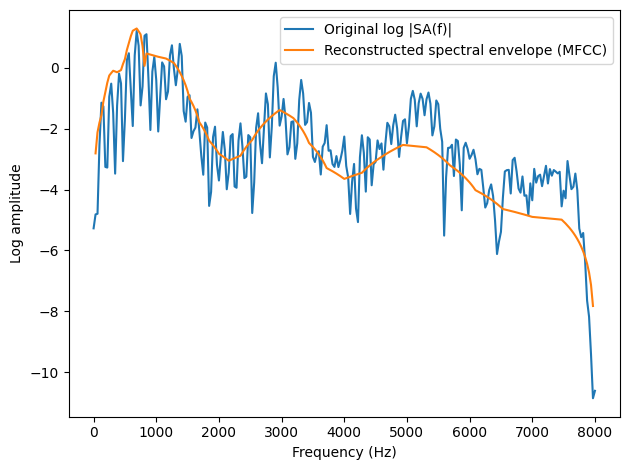

In [15]:
plt.close()

# ==========================================
# /sa/ 音声から MFCC を計算し、
# その MFCC だけから log メルスペクトル包絡を再構成して
# 元の log 振幅スペクトルと比較する処理
# （MFCC がスペクトル包絡をどの程度保存しているかを見る）
# ==========================================

# 1. 音声の読み込みとプリエンファシス
# ------------------------------------------
# /sa/ 音声を 16 kHz で読み込み
ySa, sr = librosa.load("sa48k.wav", sr=16000)

# プリエンファシスフィルタ y[n] = x[n] - 0.97 x[n-1]
# → 1/f 型のスペクトル傾斜を補正し、高域を相対的に強調して
#   フォルマント構造などの包絡が見やすくなるようにする
ySa = signal.lfilter([1, -0.97], 1, ySa)

# 2. 短時間フレームの取得と FFT
# ------------------------------------------
nFFT = 512  # 分析窓長（≈ 32 ms）
# 7000 サンプル目から 512 サンプル分を切り出し、Hann 窓をかける
# → 1 フレーム分の /a/ 近傍を見ている想定
yA = ySa[7000 + np.arange(nFFT)] * np.hanning(nFFT)

# rFFT による片側振幅スペクトル（複素数）
SA = np.fft.rfft(yA)

# 周波数軸 [Hz]
f = np.fft.rfftfreq(nFFT, 1 / sr)

# 3. メルフィルタバンクでの周波数圧縮
# ------------------------------------------
nBank = 40  # メルフィルタの本数（次元数）

# 自作の melbank() で三角形メルフィルタバンクを生成
# melFilterBank : shape = (nBank, nFFT/2+1)
#   各行が 1 本のメルフィルタの周波数応答（正規化済み）
# _ : 各フィルタの中心周波数（ここでは未使用）
melFilterBank, _ = melbank(fs=sr, nfft=nFFT, nbank=nBank, lower=0, upper=sr / 2)

# メルフィルタバンクによるバンド積分
# melFilterBank @ |SA| で、
# 物理周波数軸上のスペクトル |SA(f)| をメルバンドごとに集約
# → melSA[k] は k 番目のメルバンドにおける総エネルギー（のような量）
melSA = np.log(melFilterBank @ np.abs(SA))

# 4. DCT による MFCC 計算と「低次成分だけ」の保持
# ------------------------------------------
order = 13  # 残す MFCC の次数（0 次を除いて 13 次まで）

# DCT（離散コサイン変換）で log メルスペクトルを「ケフレンシ（que-frency）」軸に写像
# → 周波数分解能の粗いローパスフィルタに相当し、
#   低次の係数が「なめらかなスペクトル包絡」に対応する
mfccSA = scipy.fft.dct(melSA)

# 高次成分（order+1 以降）を 0 にするリフタリング
# → メル包絡のうち、「なめらかな成分だけ」を残す操作
mfccSA[order + 1 :] = 0

# 0 次係数（全体の log パワー）はここでは 0 にする
# → 絶対的な音量ではなく、形状（フォルマント構造）だけを見たい、という意図
mfccSA[0] = 0

# 5. MFCC から log メルスペクトル包絡を再構成
# ------------------------------------------
# IDCT（逆 DCT）により、
# 「低次 MFCC だけ」から log メルスペクトルを再構成
# → 高次成分を落としているので、細かい凹凸の少ない平滑な包絡になる
melSA_env = scipy.fft.idct(mfccSA)

# 再構成した log メルスペクトルを、再びメルフィルタバンクの重ね合わせで
# 元の物理周波数軸上に写像して、log スペクトル包絡を得る：
#   exp(melSA_env) : メルバンドごとの線形スケールのエネルギー
#   melFilterBank.T : (nFFT/2+1, nBank)
#   np.sum(..., axis=1) : 各周波数ビンに対して、全メルバンドのエネルギーを合計
# 結果として、"メル包絡" を物理周波数軸に逆投影した
# なめらかなスペクトル包絡が得られる
spec_env = np.sum(np.exp(melSA_env) * melFilterBank.T, axis=1)

# 6. 元の log 振幅スペクトルと包絡の比較プロット
# ------------------------------------------
# 元の log 振幅スペクトル（プリエンファシス + 窓掛け後）
plt.plot(f, np.log(np.abs(SA)), label="Original log |SA(f)|")

# MFCC から再構成したスペクトル包絡
plt.plot(f, np.log(spec_env), label="Reconstructed spectral envelope (MFCC)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Log amplitude")
plt.legend()
plt.tight_layout()

# fig = plt.gcf()
# fig.savefig('fig06_33.eps')

# この図で：
#   ・細かいハーモニクス構造（ピッチの整数倍のピーク）は「Original」にのみ現れ、
#   ・再構成包絡はフォルマント付近のなめらかなピークだけを残している
# ことが確認できると、
# 「MFCC は細かいハーモニクスではなく、スペクトル包絡＝音色情報を主に表現している」
# という理論的説明ときれいに対応する。